In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
resultDatasetPath = "../dataset/no_outliers_tweets.h5"

In [3]:
%%time
datasetTweetsCleanedPath = "../dataset/clean_datatype_tweets.h5"
df_tweets = pd.read_hdf(datasetTweetsCleanedPath)

CPU times: user 5.2 s, sys: 5 s, total: 10.2 s
Wall time: 10.6 s


In [4]:
print(df_tweets.dtypes)
df_tweets

user_id                  float64
retweet_count            float64
reply_count              float64
favorite_count           float64
num_hashtags             float64
num_urls                 float64
num_mentions             float64
created_at        datetime64[ns]
text                      object
dtype: object


,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
0,3.277463e+08,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-11 14:53:55,"if man is a little lower than angels, then ang..."
1,3.337229e+08,1.0,0.0,0.0,0.0,0.0,1.0,2020-04-01 20:27:04,"""@bestwshhvids: how do you say these words wit..."
2,2.379756e+09,0.0,0.0,0.0,0.0,0.0,1.0,2019-05-02 13:34:31,@lolatcomedy awsome
3,4.662269e+08,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-04 07:17:37,stephen hawkins: i buchi neri non esistono se ...
4,1.355538e+09,114.0,0.0,0.0,1.0,0.0,1.0,2020-03-11 16:45:31,rt @tibbs_montris: so ready for wednesday!
...,...,...,...,...,...,...,...,...,...
11712086,2.209330e+08,0.0,0.0,0.0,0.0,0.0,0.0,2018-05-04 05:29:33,esta manana aun esta muy frio ! miren esto ! ...
11712087,5.874910e+08,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-17 02:51:53,"@warriors congrats, maybe i'll be able to get ..."
11712088,9.178130e+07,0.0,NaN,NaN,NaN,0.0,NaN,2016-07-10 22:43:09,NaN
11712089,1.278956e+08,0.0,0.0,1.0,1.0,0.0,0.0,2019-03-07 19:56:55,shooting crew of porn movies. #theworstjobtohave


In [5]:
# compute the interquartile range and set the median to df.attr of the outliers 
def compute_outliers(df, attr):
    Q1 = df[attr].quantile(0.25)
    Q3 = df[attr].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range
    print("Q1:", Q1, "Q3:", Q3, "IQR:", IQR)
    #filter = (df[attr] >= Q1 - 1.5 * IQR) & (df[attr] <= Q3 + 1.5 * IQR)
    #valid = df.loc[filter]
    filter = (df[attr] < Q1 - 1.5 * IQR) | (df[attr] > Q3 + 1.5 * IQR)
    outliers = df.loc[filter]
    
    print("We have", len(outliers), "outliers over", len(df), "entries (", (len(outliers) / len(df)) * 100, "%)")
    
    return outliers

In [6]:
def hist(df, column):
    numberOfBins = int(np.log2(len(df[column][df[column].notna()])) + 1)
    print("Number of bins:", numberOfBins)
    df[column].plot(kind='hist', title=column, bins=numberOfBins)
    plt.ylabel("count")
    plt.show()

def boxplot(df, column):
    df.boxplot(column=column)
    plt.show()

def log_scale(df, column):
    return pd.DataFrame(np.log10(1+df[column][df[column].notna()]))

def analyze_outliers(df, column, upper_bound):
    hist(df, column)
    boxplot(df, column)
    
    print("\n\nLog scale")
    column_log_scale = log_scale(df, column)
    hist(column_log_scale, column)
    boxplot(column_log_scale, column)
    
    print("\n\nUpper bound:", upper_bound)
    limited = df[df[column] <= upper_bound]
    hist(limited, column)
    boxplot(limited, column)
    
    print("\n\nLog scale with upper bound:", upper_bound)
    limited_log_scale = log_scale(limited, column)
    hist(limited_log_scale, column)
    boxplot(limited_log_scale, column)

    # compute outliers from limited log scale
    outliers = compute_outliers(limited_log_scale, column)
    minOutlierValue = df.loc[outliers.index][column].min()
    maxOutlierValue = df.loc[outliers.index][column].max()
    print("Min outlier:", minOutlierValue, "   Max outlier:", maxOutlierValue)

    return outliers

def fillna_grouby_userid(df, attr):
    df[attr].fillna(df.groupby(["user_id"])[attr].transform(lambda x: np.nanmedian(x)), inplace=True)

Number of bins: 24


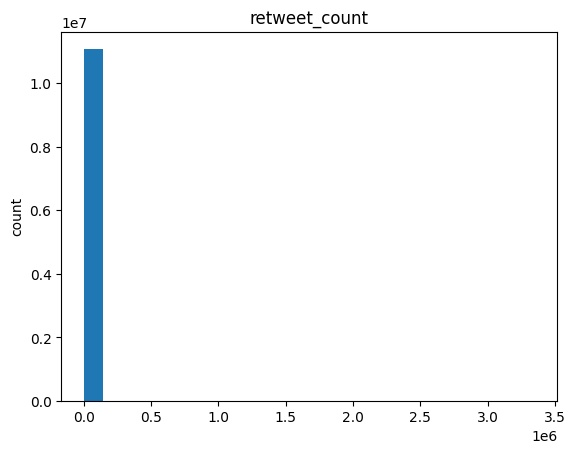

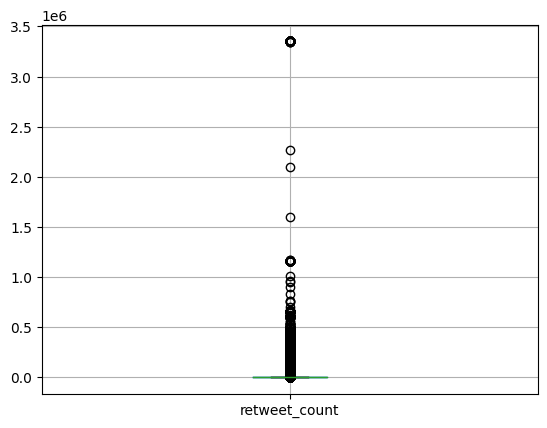



Log scale
Number of bins: 24


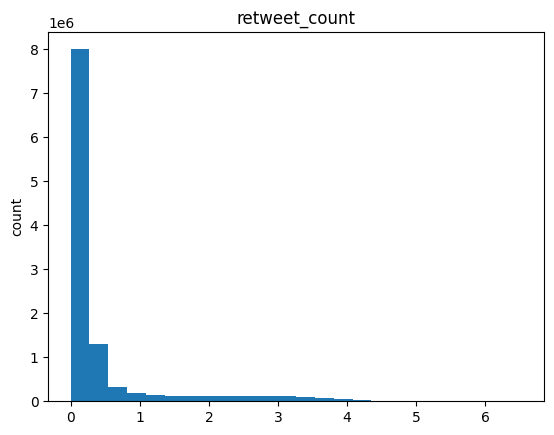

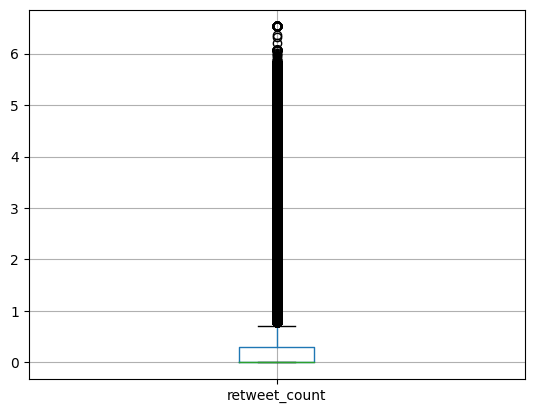



Upper bound: 4000000
Number of bins: 24


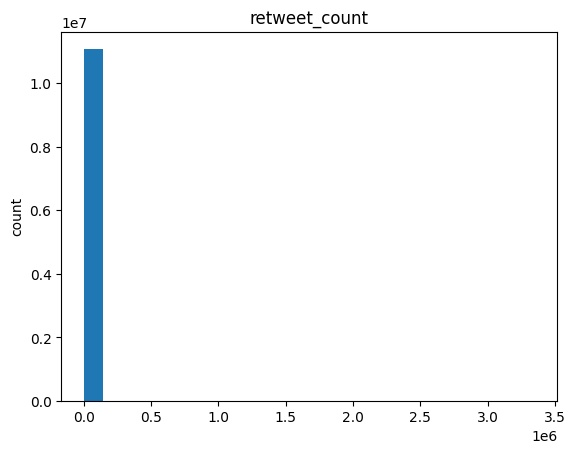

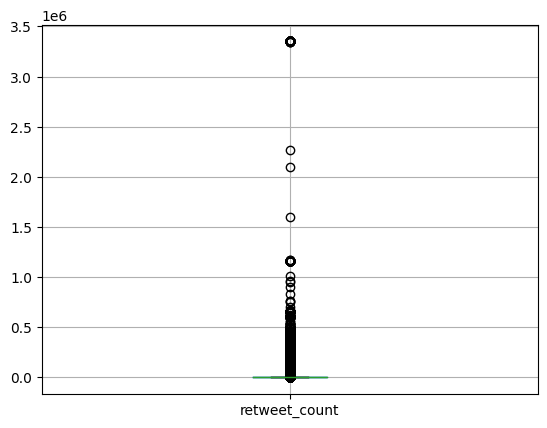



Log scale with upper bound: 4000000
Number of bins: 24


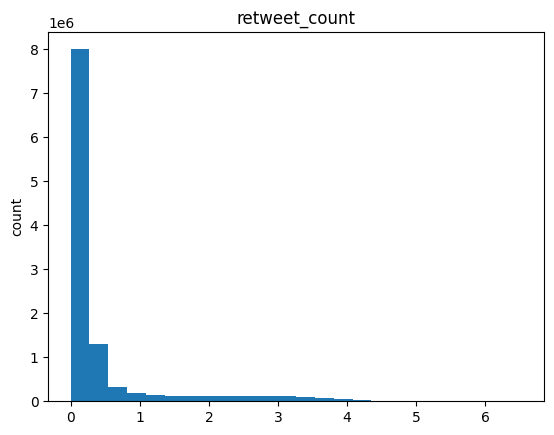

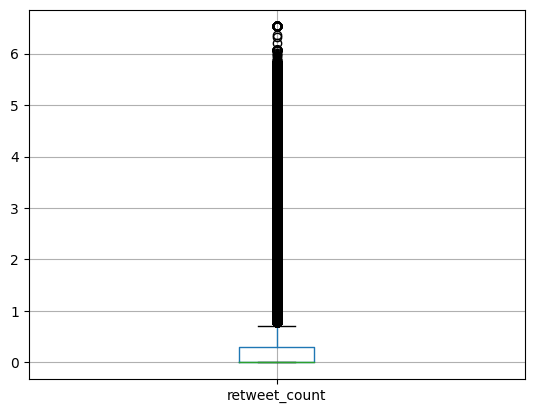

Q1: 0.0 Q3: 0.3010299956639812 IQR: 0.3010299956639812
We have 1527557 outliers over 11071721 entries ( 13.796924615423384 %)
Min outlier: 5.0    Max outlier: 3350111.0


In [7]:
outliers = analyze_outliers(df_tweets, "retweet_count", 4000000)

In [8]:
df_tweets.loc[outliers.index, "retweet_count"] = np.nan

In [9]:
fillna_grouby_userid(df_tweets, "retweet_count")

/home/dferraro/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [10]:
df_tweets.describe()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,1.126316e+07,1.154586e+07,1.088779e+07,1.088909e+07,1.053363e+07,1.088803e+07,1.070914e+07
mean,2.663551e+289,2.348686e-01,1.836921e+103,2.466510e+00,1.766668e-01,1.652920e-01,5.262895e-01
std,inf,6.503741e-01,6.061222e+106,6.132943e+02,6.759432e-01,4.963056e-01,8.678002e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.328048e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.680803e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.232535e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,3.000000e+296,4.000000e+00,2.000000e+110,9.224620e+05,1.990000e+02,1.950000e+02,2.000000e+02


# Save on file

In [11]:
df_tweets.to_hdf(resultDatasetPath, 'df_tweets', mode='w')

/tmp/ipykernel_10537/87023771.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['text'], dtype='object')]

  df_tweets.to_hdf(resultDatasetPath, 'df_tweets', mode='w')
